## Visualize signature features

**Gregory Way, 2020**

The signature building efforts in `1.derive-bulk-signatures.ipynb` take all Cell Painting features and reduce them to a set of features that most distinguish sensitive from resistant clones.
We also remove features that contribute to technical artifacts.
Visualize these scores here.

In [1]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(UpSetR))
suppressPackageStartupMessages(library(ggrepel))

In [2]:
seed <- 1234
set.seed(seed)

datasets <- c(
    "cloneAE" = "Bortezomib",
    "ixazomib" = "Ixazomib",
    "cb5083" = "CB-5083"
)

signature_dir <- file.path("results", "signatures")

anova_file <- file.path(signature_dir, "anova_results_full_bulk_signature.tsv.gz")
tukey_file <- file.path(signature_dir, "tukey_results_full_bulk_signature.tsv.gz")
cell_count_file <- file.path(signature_dir, "lm_cell_count_results_full_bulk_signature.tsv.gz")
summary_file <- file.path(signature_dir, "signature_summary_full_bulk_signature.tsv")

output_fig_dir <- file.path("figures", "signature_features")

In [3]:
# Load data
anova_cols <- readr::cols(
    term = readr::col_character(),
    df = readr::col_integer(),
    sumsq = readr::col_double(),
    meansq = readr::col_double(),
    statistic = readr::col_double(),
    p.value = readr::col_double(),
    feature = readr::col_character(),
    neg_log_p = readr::col_double(),
    dataset = readr::col_character()
)

anova_df <- readr::read_tsv(anova_file, col_types = anova_cols)

tukey_cols <- readr::cols(
    term = readr::col_character(),
    comparison = readr::col_character(),
    estimate = readr::col_double(),
    conf.low = readr::col_double(),
    conf.high = readr::col_double(),
    adj.p.value = readr::col_double(),
    feature = readr::col_character(),
    neg_log_adj_p = readr::col_double(),
    dataset = readr::col_character()
)

tukey_df <- readr::read_tsv(tukey_file, col_types = tukey_cols)

cell_count_cols <- readr::cols(
    term = readr::col_character(),
    estimate = readr::col_double(),
    std.error = readr::col_double(),
    statistic = readr::col_double(),
    p.value = readr::col_double(),
    feature = readr::col_character(),
    rsquared = readr::col_double(),
    neg_log_p = readr::col_double()
)

cell_count_df <- readr::read_tsv(cell_count_file, col_types = cell_count_cols)

summary_cols <- readr::cols(
    features = readr::col_character(),
    non_status_significant_exclude = readr::col_character(),
    cell_count_exclude = readr::col_character(),
    plate_exclude = readr::col_character(),
    batch_exclude = readr::col_character(),
    non_specific_exclude = readr::col_character(),
    final_signature = readr::col_character(),
    dataset = readr::col_character()
)

summary_df <- readr::read_tsv(summary_file, col_types = summary_cols)

## Plot ANOVA results

The ANOVA will tell us which terms impact specific feature differences.

We performed this experiment for each dataset independently.

In [4]:
# Identify significance line
num_cp_features <- length(unique(anova_df$feature))
signif_line <- -log10(0.05 / num_cp_features)
signif_line

[1] 4.082067

In [5]:
# Split features into categories
anova_df <- anova_df %>%
    tidyr::separate(
        feature,
        into = c(
            "compartment",
            "feature_group",
            "measurement",
            "channel", 
            "parameter1", 
            "parameter2"
        ),
        sep = "_",
        remove = FALSE
    ) %>%
    dplyr::mutate(compartment_feature_group = paste(compartment, feature_group, sep=" - "))

head(anova_df, 2)

Warning message:
“Expected 6 pieces. Missing pieces filled with `NA` in 2424 rows [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, ...].”

term,df,sumsq,meansq,statistic,p.value,feature,compartment,feature_group,measurement,channel,parameter1,parameter2,neg_log_p,dataset,compartment_feature_group
<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>
Metadata_clone_type_indicator,1,0.0500812,0.0500812,0.4297165,5.199873e-01,Cells_AreaShape_Compactness,Cells,AreaShape,Compactness,NA,NA,NA,0.2840073,cloneAE,Cells - AreaShape
Metadata_batch,2,10.1286855,5.0643427,43.4540613,8.153257e-08,Cells_AreaShape_Compactness,Cells,AreaShape,Compactness,NA,NA,NA,7.0886689,cloneAE,Cells - AreaShape


In [6]:
cell_count_df <- cell_count_df %>%
    tidyr::separate(
        feature,
        into = c(
            "compartment",
            "feature_group",
            "measurement",
            "channel", 
            "parameter1", 
            "parameter2"
        ),
        sep = "_",
        remove = FALSE
    ) %>%
    dplyr::mutate(compartment_feature_group = paste(compartment, feature_group, sep=" - "))

head(cell_count_df)

Warning message:
“Expected 6 pieces. Missing pieces filled with `NA` in 2193 rows [1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20, 21, 22, ...].”

term,estimate,std.error,statistic,p.value,feature,compartment,feature_group,measurement,channel,parameter1,parameter2,rsquared,neg_log_p,dataset,compartment_feature_group
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>
(Intercept),-0.7145131,0.05115001,-13.96897,4.213022e-12,Cytoplasm_Granularity_11_RNA,Cytoplasm,Granularity,11,RNA,NA,NA,0.51615455,11.375406,cloneAE,Cytoplasm - Granularity
(Intercept),0.9027496,0.07270346,12.41687,3.869015e-11,Cells_Correlation_Overlap_ER_RNA,Cells,Correlation,Overlap,ER,RNA,NA,0.03267971,10.412400,cloneAE,Cells - Correlation
(Intercept),-0.6916685,0.05960757,-11.60370,1.349242e-10,Cells_Granularity_10_RNA,Cells,Granularity,10,RNA,NA,NA,0.21368468,9.869910,cloneAE,Cells - Granularity
(Intercept),-0.7766077,0.07214558,-10.76445,5.253117e-10,Nuclei_RadialDistribution_RadialCV_DNA_3of4,Nuclei,RadialDistribution,RadialCV,DNA,3of4,NA,0.45360089,9.279583,cloneAE,Nuclei - RadialDistribution
(Intercept),-0.7297740,0.06833237,-10.67977,6.050638e-10,Cells_Granularity_10_AGP,Cells,Granularity,10,AGP,NA,NA,0.42622731,9.218199,cloneAE,Cells - Granularity
(Intercept),-0.7708758,0.07317789,-10.53427,7.728062e-10,Nuclei_Granularity_10_AGP,Nuclei,Granularity,10,AGP,NA,NA,0.23228136,9.111929,cloneAE,Nuclei - Granularity


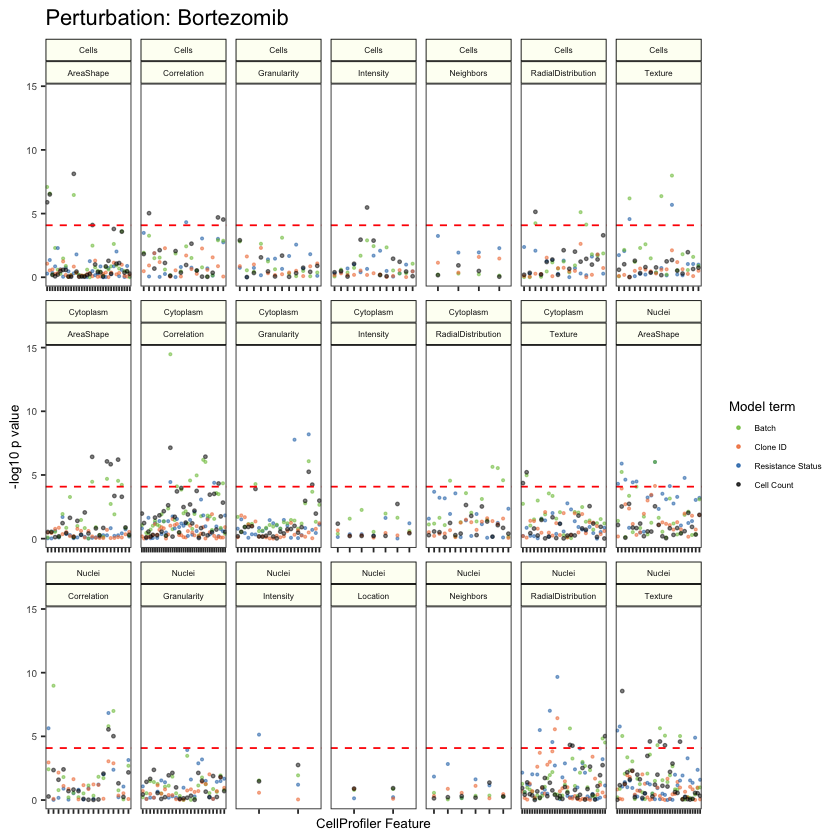

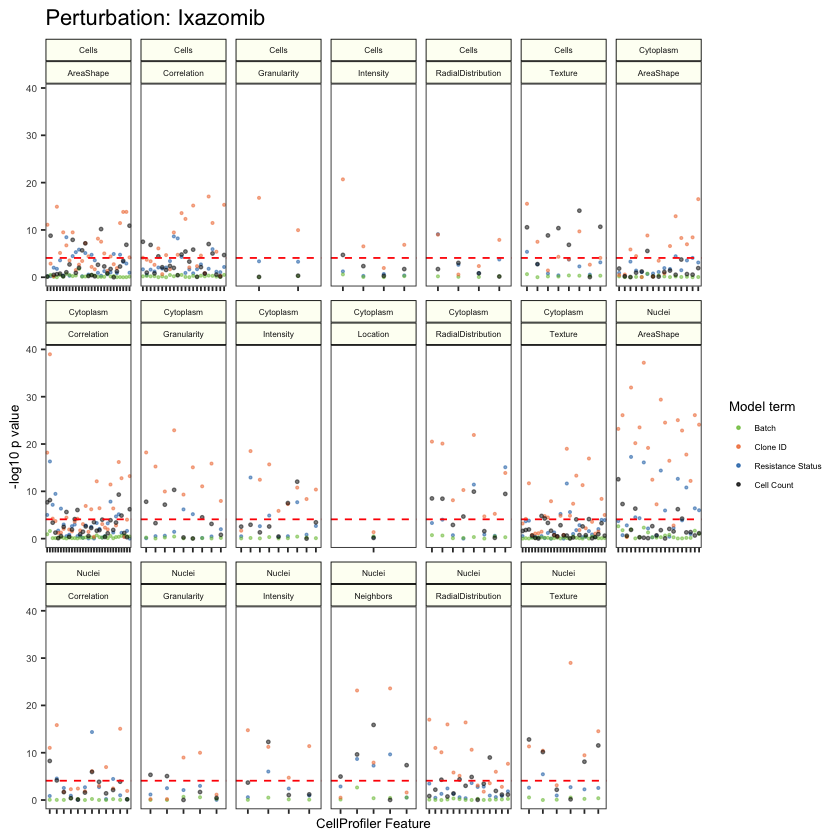

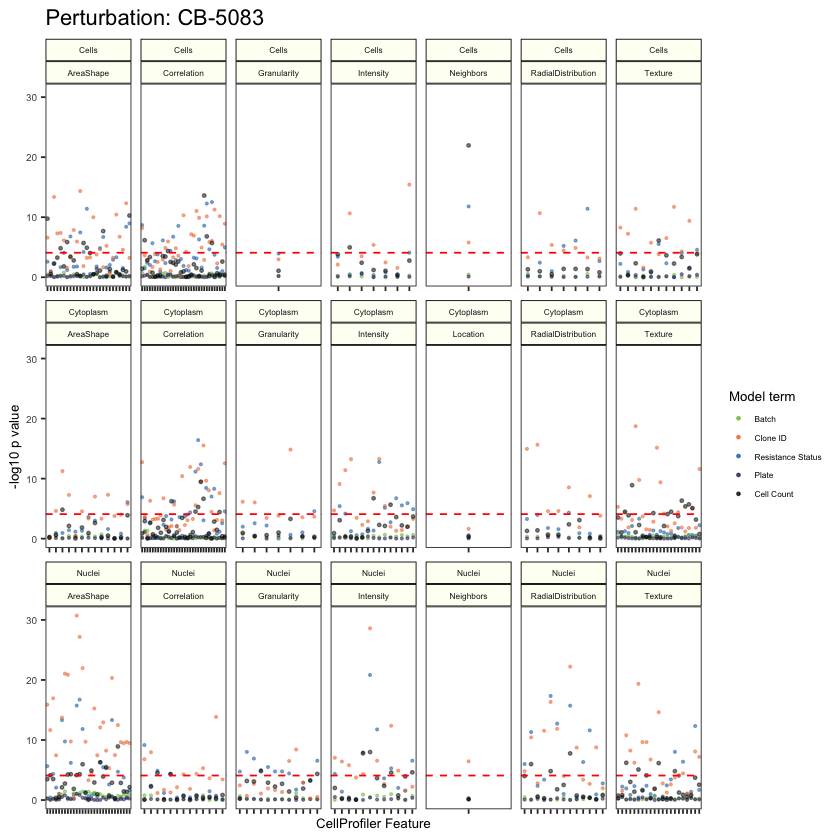

In [7]:
for (dataset in names(datasets)) {
    perturbation <- datasets[[dataset]]
    
    anova_subset <- anova_df %>%
        dplyr::filter(dataset == !!dataset, neg_log_p < 200)
    cell_count_subset <- cell_count_df %>%
        dplyr::filter(dataset == !!dataset, term == "scale(Metadata_cell_count)", neg_log_p < 200)
    
    feature_significance_gg <- ggplot(anova_subset, aes(x = feature, y = neg_log_p)) +
        geom_point(aes(color = term), size = 0.5, alpha = 0.5) +
        geom_point(data = cell_count_subset,
                   aes(color = term), size = 0.7, alpha = 0.5) +
        geom_hline(yintercept = signif_line, color = "red", linetype = "dashed") +
        theme_bw() +
        facet_wrap("compartment~feature_group", scales="free_x", ncol=7) +
        xlab("CellProfiler Feature") +
        ylab("-log10 p value") +
        ggtitle(paste("Perturbation:", perturbation)) +
        scale_color_manual(
            "Model term",
            labels = c("Metadata_batch" = "Batch",
                       "Metadata_clone_number" = "Clone ID",
                       "Metadata_clone_type_indicator" = "Resistance Status",
                       "scale(Metadata_cell_count)" = "Cell Count",
                       "Metadata_Plate" = "Plate"),
            values = c("Metadata_batch" = "#75BE3A",
                       "Metadata_clone_number" = "#EF7333",
                       "Metadata_clone_type_indicator" = "#146CB1",
                       "scale(Metadata_cell_count)" = "black",
                       "Metadata_Plate" = "#301B65")
        ) +
        theme(
            axis.text.x = element_blank(),
            panel.grid.major = element_blank(),
            panel.grid.minor = element_blank(),
            legend.title = element_text(size = 8),
            legend.text = element_text(size = 5),
            legend.key.size = unit(0.4, "cm"),
            axis.title = element_text(size = 8),
            axis.text.y = element_text(size = 6),
            strip.text = element_text(size = 5),
            strip.background = element_rect(colour="black", fill="#fdfff4")
        )
    
    
    output_fig_file <- file.path(output_fig_dir, paste0("signature_linear_model_results_", dataset, ".png"))
    ggsave(output_fig_file, feature_significance_gg, dpi = 500, height = 4, width = 7)
    
    print(feature_significance_gg)
}

## Generate UpSet plots

In [8]:
exclude_criteria <- colnames(summary_df %>% dplyr::select(ends_with("_exclude")))

for (dataset in names(datasets)) {
    exclude_list <- list()
    subset_summary_df <- summary_df %>% dplyr::filter(dataset == !!dataset)
    for (exclude in exclude_criteria) {
        exclude_name <- stringr::str_remove(exclude, "_exclude")

        exclude_list[[exclude_name]] <- subset_summary_df %>%
            dplyr::select(features, !!exclude) %>%
            dplyr::filter(!!as.symbol(exclude) == "TRUE") %>%
            dplyr::pull(features)
    }
    
    filename <- file.path(output_fig_dir, paste0("signature_dataset_", dataset, ".pdf"))
    
    pdf(file = filename, onefile = FALSE)
    sig_size <- length(subset_summary_df %>% dplyr::filter(final_signature == "TRUE") %>% dplyr::pull(features))
    title <- paste0("Dataset: ", dataset, "\nSignature size: ", sig_size)
    print(upset(fromList(exclude_list), order.by="freq"))
    grid::grid.text(title, x = 0.65, y = 0.95, gp=grid::gpar(fontsize = 12))
    dev.off()
}

## Visualize Tukey Results

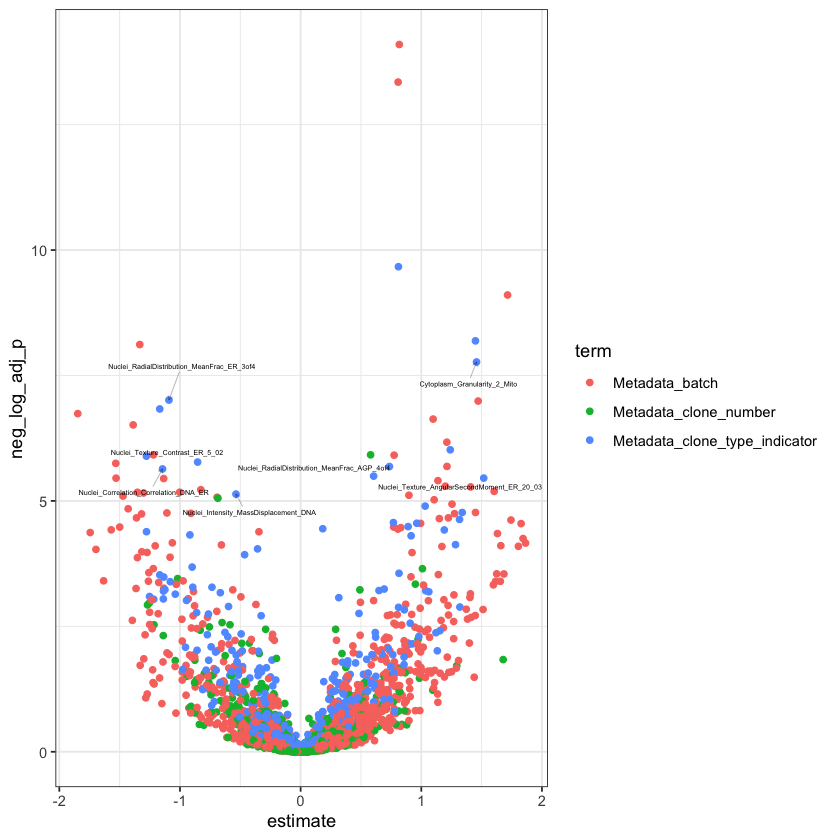

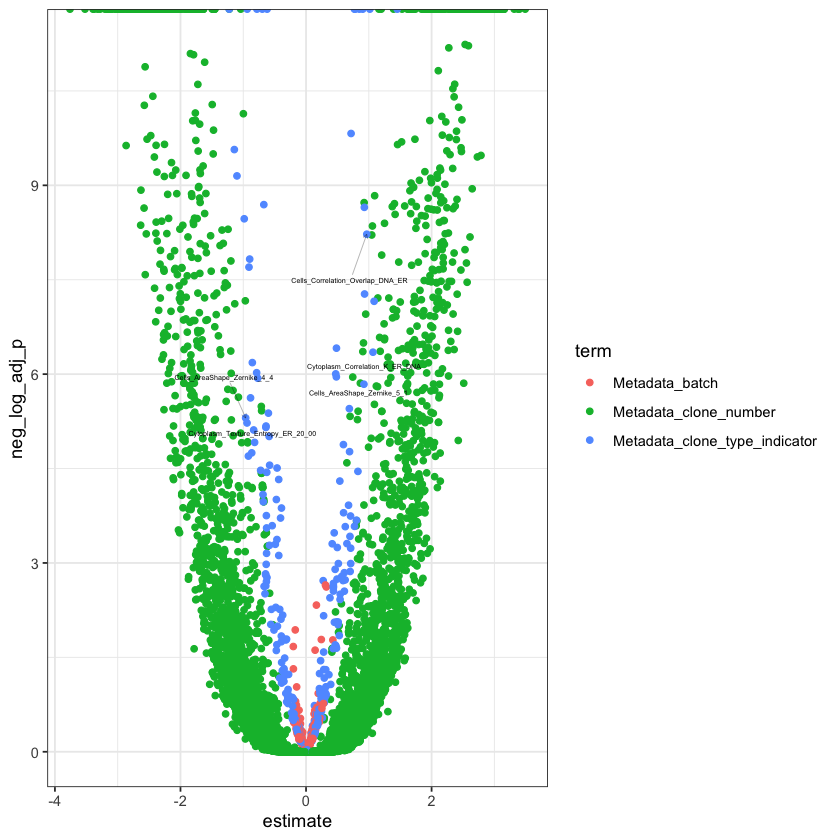

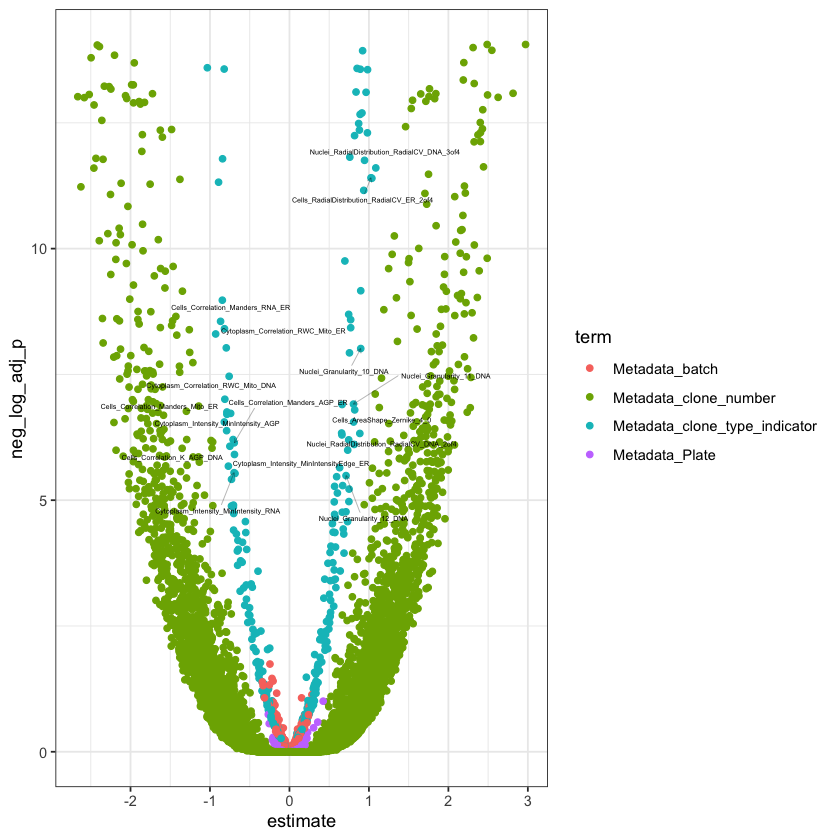

In [9]:
for (dataset in names(datasets)) {
    tukey_subset_df <- tukey_df %>%
        dplyr::filter(feature != "Cytoplasm_Correlation_Costes_RNA_Mito", dataset == !!dataset)

    final_sig <- summary_df %>%
        dplyr::filter(dataset == !!dataset, final_signature == "TRUE") %>%
        dplyr::pull(features)

    repel_logic <- (
        tukey_subset_df$dataset == dataset &
        tukey_subset_df$term == "Metadata_clone_type_indicator" &
        tukey_subset_df$neg_log_adj_p > 5 &
        tukey_subset_df$feature %in% final_sig
        )
    
    tukey_gg <- (
        ggplot(tukey_subset_df,
               aes(x=estimate, y=neg_log_adj_p)) +
        geom_point(aes(color=term)) +
        theme_bw() +
        geom_text_repel(data = subset(tukey_subset_df, repel_logic),
                    arrow = arrow(length = unit(0.01, "npc")),
                    size = 1.5,
                    segment.size = 0.1,
                    segment.alpha = 0.8,
                    force = 20,
                    aes(x = estimate,
                        y = neg_log_adj_p,
                        label = feature))
    )
    
    print(tukey_gg)
}